In [1]:
import argparse
import os, sys
from utils.data_utils import *
from glob import glob
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
%matplotlib inline  
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,9]

In [2]:
def is_windows():
    return sys.platform == 'win32'

In [3]:
res_dir = os.path.join('predictions')
if is_windows():
    l_dirs = ['0.21', '0.22', '0.23', '0.24', '0.25']
else:
    l_dirs = ['0.09']

In [30]:
train_augmented = False
valid_augmented = True

In [5]:
def get_data_dir(a, t):
    if t:
        if a:
            data_dir = 'train_ex'
        else:
            data_dir = 'train'
    else:
        if a:
            data_dir = 'valid_ex'
        else:
            data_dir = 'valid'
    return data_dir

def load_loss_df(l_dirs, augmented=False, train=False):
    data_dir = get_data_dir(augmented, train)
    dataframes = []
    for d in l_dirs:
        dataframes.append(pd.read_csv(os.path.join(res_dir, data_dir, d, 'models.csv')))

    df_l = pd.concat(dataframes, ignore_index=True)
    return df_l

def get_gt_name(a, t):
    if t:
        if a:
            name = 'Y_train_augmented.npz'
        else:
            name = 'Y_train.npz'
    else:
        if a:
            name = 'Y_valid_augmented.npz'
        else:
            name = 'Y_valid.npz'
    return name

def load_ground_truth(data_dir, augmented=False, train=False):
    gt_name = get_gt_name(augmented, train)
    y_true_path = os.path.join('augmented', data_dir, gt_name)
    y_true = npz_to_ndarray(np.load(y_true_path))
    return y_true

def load_preds(df_loss):
    preds = []
    for npz_path in df_loss.res_path:
        p = npz_to_ndarray(np.load(npz_path))
        preds.append(p)
    return np.array(preds)

def load_test_df(l_dirs):
    dataframes = []
    for d in l_dirs:
        dataframes.append(pd.read_csv(os.path.join('test_predictions', d, 'models.csv')))

    df_l = pd.concat(dataframes, ignore_index=True)
    return df_l

def load_jpg_data(df_csv, data_dir, label_map, img_size=None, subset_size=None):
    X = []
    Y = []

    # for f, tags in tqdm(df_train.sample(subset_size).values, miniters=1000):
    if subset_size is not None:
        data_progress = tqdm(df_csv.sample(subset_size).values, miniters=1000)
    else:
        data_progress = tqdm(df_csv.values, miniters=1000)

    for f, tags in data_progress:
        f_name = '{}.jpg'.format(f)
        img = cv2.imread(os.path.join(data_dir, f_name))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1
        if img_size is not None:
            X.append(cv2.resize(img, (img_size, img_size)))
        else:
            X.append(img)
        Y.append(targets)
    print("Creating numpy array for data...")
    X = np.array(X, np.float16) / 255.
    Y = np.array(Y, np.uint8)
    return X, Y

def get_labels():
    labels = [
        'slash_burn',
        'clear',
        'blooming',
        'primary',
        'cloudy',
        'conventional_mine',
        'water',
        'haze',
        'cultivation',
        'partly_cloudy',
        'artisinal_mine',
        'habitation',
        'bare_ground',
        'blow_down',
        'agriculture',
        'road',
        'selective_logging'
    ]

    l_map = {l: i for i, l in enumerate(labels)}
    inv_map = {i: l for l, i in l_map.items()}
    return labels, l_map, inv_map

In [6]:
test_data_dir = os.path.join('inputs', 'test-jpg')
labels, label_map, inv_label_map = get_labels()
df_test_submission = pd.read_csv(os.path.join('inputs', 'sample_submission_v2.csv'))
X_test, _ = load_jpg_data(df_test_submission, test_data_dir, label_map, img_size=128)

100%|██████████| 61191/61191 [00:52<00:00, 1157.89it/s]


Creating numpy array for data...


In [65]:
df_loss_valid = load_loss_df(l_dirs, augmented=valid_augmented, train=False)
len(df_loss_valid)

138

In [32]:
df_loss_train = load_loss_df(l_dirs, augmented=train_augmented, train=True)
len(df_loss_train)

138

In [8]:
df_test = load_test_df(l_dirs)
len(df_test)

137

In [68]:
preds_valid = load_preds(df_loss_valid)
preds_valid.shape

(138, 64768, 17)

In [10]:
preds_test = load_preds(df_test)
preds_test.shape

(137, 61191, 17)

In [33]:
preds_train = load_preds(df_loss_train)
preds_train.shape

(138, 32383, 17)

In [11]:
y_true_valid = load_ground_truth('train_augmented_size_128_mult_8_seed_0', augmented=valid_augmented, train=False)
y_true_valid.shape

(64768, 17)

In [34]:
y_true_train = load_ground_truth('train_augmented_size_128_mult_8_seed_0', augmented=train_augmented, train=True)
y_true_train.shape

(32383, 17)

In [12]:
best_model = df_loss_valid.score.argmax()
print("Model with best score is %d where score is %f" % (best_model, df_loss_valid.score[best_model]))
print(df_loss_valid.model[best_model])

Model with best score is 110 where score is 0.925849
net1_34_0.09


In [13]:
# best_model_train = df_loss_train.score.argmax()
# print("Model with best score on training set is %d where score is %f" % (best_model_train, df_loss_train.score[best_model_train]))
# print(df_loss_train.model[best_model_train])

In [77]:
def find_best_candidate(y_true, all_preds, cls, ensemble, ref_pred = None):
    if ref_pred is None:
        temp = all_preds[ensemble[0]].copy()
    else:
        temp = ref_pred.copy()

    best_avg_score = fbeta_score(y_true, (temp>0.2).astype(int), beta=2, average='samples')
    best_candidate = None
    for i in tqdm(range(len(all_preds))):
        if i not in ensemble:
            temp[:,cls] = np.mean([p[:,cls] for p in all_preds[ensemble]] + [all_preds[i][:,cls]], axis=0)
            score = fbeta_score(y_true, (temp>0.2).astype(int), beta=2, average='samples')
            if score > best_avg_score:
                best_avg_score = score                
                best_candidate = i             
                
    return best_candidate, best_avg_score

epsilon = 0.00001
def optimize_class_score(y_target, preds_target, cls, init_ensemble = [], ref_pred = None):
    best_ensemble = init_ensemble[:]
    best_score = 0
    counter = 0
    while True:
        best_candidate, new_avg_score = find_best_candidate(y_target, preds_target, cls, best_ensemble, ref_pred)
        sys.stdout.flush()
            
        if best_candidate is not None and (new_avg_score - best_score) > epsilon:
            best_ensemble.append(best_candidate)
            print("%d: Best candidate model is %d with improvement of %.5f" % (counter, best_candidate, new_avg_score-best_score))
            print("%d: Best ensemble %s" % (counter, best_ensemble))
            best_score = new_avg_score
            counter+=1
        else:
            print("Can't optimize class %d any more" % cls)
            break
    
    return best_ensemble, best_score

def optimize_per_class_ref_model(y_true, preds, ref_model):
    ensembles_per_class = []
    scores_per_class = []
    for cls in range(17):
        print("Optimizing class %d" % cls)
        best_ensemble_cls, best_score_cls = optimize_class_score(y_true, preds, cls, init_ensemble=[ref_model])
        print("Best score %.5f" % best_score_cls)
        print(best_ensemble_cls)
        ensembles_per_class.append(best_ensemble_cls)
        scores_per_class.append(best_score_cls)
        
    return ensembles_per_class, scores_per_class

def optimize_per_class_ref_pred(y_true, preds, ref_pred):
    ensembles_per_class = []
    scores_per_class = []
    for cls in range(17):
        print("Optimizing class %d" % cls)
        best_ensemble_cls, best_score_cls = optimize_class_score(y_true, preds, cls, ref_pred=ref_pred)
        print("Best score %.5f" % best_score_cls)
        print(best_ensemble_cls)
        ensembles_per_class.append(best_ensemble_cls)
        scores_per_class.append(best_score_cls)
        
    return ensembles_per_class, scores_per_class

def get_opt_pred(ref_p, ens_per_cls, preds):
    opt_p = ref_p.copy()
    for i in range(17):
        if len(ens_per_cls[i]) > 0:
            opt_p[:,i] = np.mean(preds[ens_per_cls[i]][:,:,i], axis=0)
    return opt_p

def get_labels():
    labels = [
        'slash_burn',
        'clear',
        'blooming',
        'primary',
        'cloudy',
        'conventional_mine',
        'water',
        'haze',
        'cultivation',
        'partly_cloudy',
        'artisinal_mine',
        'habitation',
        'bare_ground',
        'blow_down',
        'agriculture',
        'road',
        'selective_logging'
    ]

    l_map = {l: i for i, l in enumerate(labels)}
    inv_map = {i: l for l, i in l_map.items()}
    return labels, l_map, inv_map

labels, label_map, inv_label_map = get_labels()

def to_tagging(one_hot_data, inv_label_map):
    res = pd.DataFrame(index=range(len(one_hot_data)), columns=['tags'])
    for j in range(len(one_hot_data)):
        tags = []
        for i in range(17):
            if one_hot_data[j][i] == 1:
                tags.append(inv_label_map[i])
        res['tags'][j] = ' '.join(sorted(tags))
    return res

def get_test_df():
    inputs_dir = 'inputs'
    df_submission = pd.read_csv(os.path.join(inputs_dir, 'sample_submission_v2.csv'))
    return df_submission

def create_submission(pred, sufix):
    print("Reading submission dataframe")
    df_submission = get_test_df()
    print("Creating tags")
    p_tags = to_tagging(pred, inv_label_map)
    df_submission.tags = p_tags.tags
    submission_dir = os.path.join('submissions', 'ensemble_avg_test')
    if not os.path.exists(submission_dir):
        os.makedirs(submission_dir)
        
    file_name = 'submission_' + sufix + '.csv'
    print("Saving submission to file")
    df_submission.to_csv(os.path.join(submission_dir, file_name), index=False)
    print("%s created" % os.path.join(submission_dir, file_name))
    
def show_examples(data, num, cols = 4, zoom=2):
    import math
    from matplotlib.pyplot import imshow
    rows = int(math.ceil(num/cols))
    _, ax = plt.subplots(rows, cols, figsize=(cols*zoom, rows*zoom))
    for i in range(num):
        if len(ax.shape) > 1:
            ax[i // cols, i % cols].imshow((255*data[i]).astype(np.uint8))
        else:
            ax[i].imshow((255*data[i]).astype(np.uint8))
            
def val_idx_to_test(val_idx):
    return df_test[df_test.path.isin(df_loss_valid.loc[val_idx].path)].index

In [70]:
preds_val_tr = np.concatenate([preds_valid, preds_train], axis=1)
preds_val_tr.shape

(138, 97151, 17)

In [71]:
y_true_val_tr = np.concatenate([y_true_valid, y_true_train], axis=0)
y_true_val_tr.shape

(97151, 17)

In [78]:
# Optimizing per class usign reference model 110 on validation and train
ens_110_val_tr, scores_110_val_tr = optimize_per_class_ref_model(y_true_val_tr, preds_val_tr, ref_model=110)
print("Done\n")
for cls in range(17):
    print("Best score for class %d is %.5f" % (cls, scores_110_val_tr[cls]))
    print(ens_110_val_tr[cls])

preds_opt_110_val_tr = get_opt_pred(preds_valid[110], ens_110_val_tr, preds_valid)
final_score_110_val_tr = fbeta_score(y_true_valid, (preds_opt_110_val_tr>0.2).astype(int), beta=2, average='samples')
print("Optimized score %.5f" % final_score_110_val_tr)

  0%|          | 0/138 [00:00<?, ?it/s]

Optimizing class 0


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 4 with improvement of 0.92764
0: Best ensemble [110, 4]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 0 any more
Best score 0.92764
[110, 4]
Optimizing class 1


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 46 with improvement of 0.92795
0: Best ensemble [110, 46]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 79 with improvement of 0.00006
1: Best ensemble [110, 46, 79]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 1 any more
Best score 0.92801
[110, 46, 79]
Optimizing class 2


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 58 with improvement of 0.92790
0: Best ensemble [110, 58]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 2 any more
Best score 0.92790
[110, 58]
Optimizing class 3


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 46 with improvement of 0.92803
0: Best ensemble [110, 46]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 120 with improvement of 0.00005
1: Best ensemble [110, 46, 120]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 68 with improvement of 0.00002
2: Best ensemble [110, 46, 120, 68]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 137 with improvement of 0.00004
3: Best ensemble [110, 46, 120, 68, 137]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 3 any more
Best score 0.92814
[110, 46, 120, 68, 137]
Optimizing class 4


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 46 with improvement of 0.92788
0: Best ensemble [110, 46]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 117 with improvement of 0.00009
1: Best ensemble [110, 46, 117]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 130 with improvement of 0.00003
2: Best ensemble [110, 46, 117, 130]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 26 with improvement of 0.00001
3: Best ensemble [110, 46, 117, 130, 26]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 4 any more
Best score 0.92801
[110, 46, 117, 130, 26]
Optimizing class 5


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 13 with improvement of 0.92773
0: Best ensemble [110, 13]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 5 any more
Best score 0.92773
[110, 13]
Optimizing class 6


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 12 with improvement of 0.92865
0: Best ensemble [110, 12]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 13 with improvement of 0.00030
1: Best ensemble [110, 12, 13]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 70 with improvement of 0.00007
2: Best ensemble [110, 12, 13, 70]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 137 with improvement of 0.00007
3: Best ensemble [110, 12, 13, 70, 137]


  0%|          | 0/138 [00:00<?, ?it/s]

4: Best candidate model is 76 with improvement of 0.00008
4: Best ensemble [110, 12, 13, 70, 137, 76]


  0%|          | 0/138 [00:00<?, ?it/s]

5: Best candidate model is 119 with improvement of 0.00007
5: Best ensemble [110, 12, 13, 70, 137, 76, 119]


  0%|          | 0/138 [00:00<?, ?it/s]

6: Best candidate model is 100 with improvement of 0.00001
6: Best ensemble [110, 12, 13, 70, 137, 76, 119, 100]


  0%|          | 0/138 [00:00<?, ?it/s]

7: Best candidate model is 82 with improvement of 0.00002
7: Best ensemble [110, 12, 13, 70, 137, 76, 119, 100, 82]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 6 any more
Best score 0.92928
[110, 12, 13, 70, 137, 76, 119, 100, 82]
Optimizing class 7


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 46 with improvement of 0.92801
0: Best ensemble [110, 46]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 13 with improvement of 0.00011
1: Best ensemble [110, 46, 13]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 119 with improvement of 0.00004
2: Best ensemble [110, 46, 13, 119]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 85 with improvement of 0.00003
3: Best ensemble [110, 46, 13, 119, 85]


  0%|          | 0/138 [00:00<?, ?it/s]

4: Best candidate model is 59 with improvement of 0.00003
4: Best ensemble [110, 46, 13, 119, 85, 59]


  0%|          | 0/138 [00:00<?, ?it/s]

5: Best candidate model is 74 with improvement of 0.00002
5: Best ensemble [110, 46, 13, 119, 85, 59, 74]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 7 any more
Best score 0.92824
[110, 46, 13, 119, 85, 59, 74]
Optimizing class 8


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 49 with improvement of 0.92808
0: Best ensemble [110, 49]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 137 with improvement of 0.00017
1: Best ensemble [110, 49, 137]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 94 with improvement of 0.00007
2: Best ensemble [110, 49, 137, 94]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 122 with improvement of 0.00005
3: Best ensemble [110, 49, 137, 94, 122]


  0%|          | 0/138 [00:00<?, ?it/s]

4: Best candidate model is 51 with improvement of 0.00004
4: Best ensemble [110, 49, 137, 94, 122, 51]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 8 any more
Best score 0.92842
[110, 49, 137, 94, 122, 51]
Optimizing class 9


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 137 with improvement of 0.92784
0: Best ensemble [110, 137]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 49 with improvement of 0.00012
1: Best ensemble [110, 137, 49]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 120 with improvement of 0.00003
2: Best ensemble [110, 137, 49, 120]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 123 with improvement of 0.00004
3: Best ensemble [110, 137, 49, 120, 123]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 9 any more
Best score 0.92802
[110, 137, 49, 120, 123]
Optimizing class 10


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 127 with improvement of 0.92768
0: Best ensemble [110, 127]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 125 with improvement of 0.00002
1: Best ensemble [110, 127, 125]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 62 with improvement of 0.00001
2: Best ensemble [110, 127, 125, 62]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 10 any more
Best score 0.92771
[110, 127, 125, 62]
Optimizing class 11


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 25 with improvement of 0.92787
0: Best ensemble [110, 25]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 8 with improvement of 0.00010
1: Best ensemble [110, 25, 8]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 4 with improvement of 0.00003
2: Best ensemble [110, 25, 8, 4]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 132 with improvement of 0.00002
3: Best ensemble [110, 25, 8, 4, 132]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 11 any more
Best score 0.92802
[110, 25, 8, 4, 132]
Optimizing class 12


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 22 with improvement of 0.92790
0: Best ensemble [110, 22]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 68 with improvement of 0.00010
1: Best ensemble [110, 22, 68]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 94 with improvement of 0.00004
2: Best ensemble [110, 22, 68, 94]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 137 with improvement of 0.00002
3: Best ensemble [110, 22, 68, 94, 137]


  0%|          | 0/138 [00:00<?, ?it/s]

4: Best candidate model is 42 with improvement of 0.00002
4: Best ensemble [110, 22, 68, 94, 137, 42]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 12 any more
Best score 0.92808
[110, 22, 68, 94, 137, 42]
Optimizing class 13


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 4 with improvement of 0.92765
0: Best ensemble [110, 4]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 91 with improvement of 0.00001
1: Best ensemble [110, 4, 91]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 13 any more
Best score 0.92767
[110, 4, 91]
Optimizing class 14


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 76 with improvement of 0.92800
0: Best ensemble [110, 76]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 100 with improvement of 0.00018
1: Best ensemble [110, 76, 100]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 4 with improvement of 0.00007
2: Best ensemble [110, 76, 100, 4]


100%|██████████| 138/138 [00:15<00:00,  8.75it/s]


3: Best candidate model is 114 with improvement of 0.00007
3: Best ensemble [110, 76, 100, 4, 114]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 14 any more
Best score 0.92833
[110, 76, 100, 4, 114]
Optimizing class 15


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 136 with improvement of 0.92802
0: Best ensemble [110, 136]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 13 with improvement of 0.00009
1: Best ensemble [110, 136, 13]


  0%|          | 0/138 [00:00<?, ?it/s]

2: Best candidate model is 89 with improvement of 0.00006
2: Best ensemble [110, 136, 13, 89]


  0%|          | 0/138 [00:00<?, ?it/s]

3: Best candidate model is 137 with improvement of 0.00003
3: Best ensemble [110, 136, 13, 89, 137]


  0%|          | 0/138 [00:00<?, ?it/s]

4: Best candidate model is 15 with improvement of 0.00008
4: Best ensemble [110, 136, 13, 89, 137, 15]


  0%|          | 0/138 [00:00<?, ?it/s]

5: Best candidate model is 115 with improvement of 0.00003
5: Best ensemble [110, 136, 13, 89, 137, 15, 115]


  0%|          | 0/138 [00:00<?, ?it/s]

Can't optimize class 15 any more
Best score 0.92832
[110, 136, 13, 89, 137, 15, 115]
Optimizing class 16


  0%|          | 0/138 [00:00<?, ?it/s]

0: Best candidate model is 127 with improvement of 0.92779
0: Best ensemble [110, 127]


  0%|          | 0/138 [00:00<?, ?it/s]

1: Best candidate model is 135 with improvement of 0.00007
1: Best ensemble [110, 127, 135]


100%|██████████| 138/138 [00:18<00:00,  8.66it/s]


Can't optimize class 16 any more
Best score 0.92786
[110, 127, 135]
Done

Best score for class 0 is 0.92587
[110, 4]
Best score for class 1 is 0.92639
[110, 46, 79]
Best score for class 2 is 0.92624
[110, 58]
Best score for class 3 is 0.92637
[110, 46, 120, 68, 137]
Best score for class 4 is 0.92630
[110, 46, 117, 130, 26]
Best score for class 5 is 0.92596
[110, 13]
Best score for class 6 is 0.92699
[110, 12, 13, 70, 137, 76, 119, 100, 82]
Best score for class 7 is 0.92622
[110, 46, 13, 119, 85, 59, 74]
Best score for class 8 is 0.92619
[110, 49, 137, 94, 122, 51]
Best score for class 9 is 0.92618
[110, 137, 49, 120, 123]
Best score for class 10 is 0.92595
[110, 127, 125, 62]
Best score for class 11 is 0.92620
[110, 25, 8, 4, 132]
Best score for class 12 is 0.92631
[110, 22, 68, 94, 137, 42]
Best score for class 13 is 0.92589
[110, 4, 91]
Best score for class 14 is 0.92653
[110, 76, 100, 4, 114]
Best score for class 15 is 0.92659
[110, 136, 13, 89, 137, 15, 115]
Best score for class 16

In [79]:
pred_ref = preds_test[val_idx_to_test([110])[0]]
ens_best_test = [val_idx_to_test(i) for i in ens_110_val_tr]
opt_pred_best = get_opt_pred(pred_ref, ens_best_test, preds_test)
opt_pred_best_final = (opt_pred_best>0.2).astype(int)
create_submission(opt_pred_best_final, '4')

Reading submission dataframe
Creating tags
Saving submission to file
submissions/ensemble_avg_test/submission_4.csv created


In [15]:
# Optimizing per class usign reference model 110
ens_110, scores_110 = optimize_per_class_ref_model(y_true_valid, preds_valid, ref_model=110)
print("Done\n")
for cls in range(17):
    print("Best score for class %d is %.5f" % (cls, scores_110[cls]))
    print(ens_110[cls])

preds_opt_110 = get_opt_pred(preds_valid[110], ens_110, preds_valid)
final_score_110 = fbeta_score(y_true_valid, (preds_opt_110>0.2).astype(int), beta=2, average='samples')
print("Optimized score %.5f" % final_score_110)

  0%|          | 0/137 [00:00<?, ?it/s]

Optimizing class 0


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 5 with improvement of 0.92587
0: Best ensemble [110, 5]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 0 any more
Best score 0.92587
[110, 5]
Optimizing class 1


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 47 with improvement of 0.92613
0: Best ensemble [110, 47]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 121 with improvement of 0.00016
1: Best ensemble [110, 47, 121]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 86 with improvement of 0.00002
2: Best ensemble [110, 47, 121, 86]


  0%|          | 0/137 [00:00<?, ?it/s]

3: Best candidate model is 5 with improvement of 0.00002
3: Best ensemble [110, 47, 121, 86, 5]


  0%|          | 0/137 [00:00<?, ?it/s]

4: Best candidate model is 67 with improvement of 0.00003
4: Best ensemble [110, 47, 121, 86, 5, 67]


  0%|          | 0/137 [00:00<?, ?it/s]

5: Best candidate model is 19 with improvement of 0.00001
5: Best ensemble [110, 47, 121, 86, 5, 67, 19]


  0%|          | 0/137 [00:00<?, ?it/s]

6: Best candidate model is 98 with improvement of 0.00002
6: Best ensemble [110, 47, 121, 86, 5, 67, 19, 98]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 1 any more
Best score 0.92639
[110, 47, 121, 86, 5, 67, 19, 98]
Optimizing class 2


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 105 with improvement of 0.92622
0: Best ensemble [110, 105]


  1%|          | 1/137 [00:00<00:16,  8.25it/s]

1: Best candidate model is 116 with improvement of 0.00002
1: Best ensemble [110, 105, 116]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 2 any more
Best score 0.92624
[110, 105, 116]
Optimizing class 3


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 43 with improvement of 0.92633
0: Best ensemble [110, 43]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 54 with improvement of 0.00004
1: Best ensemble [110, 43, 54]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 3 any more
Best score 0.92637
[110, 43, 54]
Optimizing class 4


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 112 with improvement of 0.92622
0: Best ensemble [110, 112]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 129 with improvement of 0.00008
1: Best ensemble [110, 112, 129]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 4 any more
Best score 0.92630
[110, 112, 129]
Optimizing class 5


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 13 with improvement of 0.92596
0: Best ensemble [110, 13]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 5 any more
Best score 0.92596
[110, 13]
Optimizing class 6


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 15 with improvement of 0.92658
0: Best ensemble [110, 15]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 70 with improvement of 0.00025
1: Best ensemble [110, 15, 70]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 86 with improvement of 0.00010
2: Best ensemble [110, 15, 70, 86]


  0%|          | 0/137 [00:00<?, ?it/s]

3: Best candidate model is 40 with improvement of 0.00006
3: Best ensemble [110, 15, 70, 86, 40]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 6 any more
Best score 0.92699
[110, 15, 70, 86, 40]
Optimizing class 7


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 119 with improvement of 0.92606
0: Best ensemble [110, 119]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 31 with improvement of 0.00013
1: Best ensemble [110, 119, 31]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 102 with improvement of 0.00002
2: Best ensemble [110, 119, 31, 102]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 7 any more
Best score 0.92622
[110, 119, 31, 102]
Optimizing class 8


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 49 with improvement of 0.92608
0: Best ensemble [110, 49]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 72 with improvement of 0.00011
1: Best ensemble [110, 49, 72]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 8 any more
Best score 0.92619
[110, 49, 72]
Optimizing class 9


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 54 with improvement of 0.92605
0: Best ensemble [110, 54]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 125 with improvement of 0.00013
1: Best ensemble [110, 54, 125]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 9 any more
Best score 0.92618
[110, 54, 125]
Optimizing class 10


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 125 with improvement of 0.92592
0: Best ensemble [110, 125]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 65 with improvement of 0.00003
1: Best ensemble [110, 125, 65]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 10 any more
Best score 0.92595
[110, 125, 65]
Optimizing class 11


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 129 with improvement of 0.92608
0: Best ensemble [110, 129]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 8 with improvement of 0.00004
1: Best ensemble [110, 129, 8]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 104 with improvement of 0.00003
2: Best ensemble [110, 129, 8, 104]


  0%|          | 0/137 [00:00<?, ?it/s]

3: Best candidate model is 14 with improvement of 0.00002
3: Best ensemble [110, 129, 8, 104, 14]


  0%|          | 0/137 [00:00<?, ?it/s]

4: Best candidate model is 23 with improvement of 0.00002
4: Best ensemble [110, 129, 8, 104, 14, 23]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 11 any more
Best score 0.92620
[110, 129, 8, 104, 14, 23]
Optimizing class 12


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 22 with improvement of 0.92617
0: Best ensemble [110, 22]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 68 with improvement of 0.00010
1: Best ensemble [110, 22, 68]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 32 with improvement of 0.00002
2: Best ensemble [110, 22, 68, 32]


  0%|          | 0/137 [00:00<?, ?it/s]

3: Best candidate model is 67 with improvement of 0.00003
3: Best ensemble [110, 22, 68, 32, 67]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 12 any more
Best score 0.92631
[110, 22, 68, 32, 67]
Optimizing class 13


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 87 with improvement of 0.92589
0: Best ensemble [110, 87]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 13 any more
Best score 0.92589
[110, 87]
Optimizing class 14


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 105 with improvement of 0.92625
0: Best ensemble [110, 105]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 94 with improvement of 0.00005
1: Best ensemble [110, 105, 94]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 42 with improvement of 0.00005
2: Best ensemble [110, 105, 94, 42]


  0%|          | 0/137 [00:00<?, ?it/s]

3: Best candidate model is 109 with improvement of 0.00005
3: Best ensemble [110, 105, 94, 42, 109]


  0%|          | 0/137 [00:00<?, ?it/s]

4: Best candidate model is 44 with improvement of 0.00004
4: Best ensemble [110, 105, 94, 42, 109, 44]


  0%|          | 0/137 [00:00<?, ?it/s]

5: Best candidate model is 99 with improvement of 0.00002
5: Best ensemble [110, 105, 94, 42, 109, 44, 99]


  0%|          | 0/137 [00:00<?, ?it/s]

6: Best candidate model is 15 with improvement of 0.00003
6: Best ensemble [110, 105, 94, 42, 109, 44, 99, 15]


  0%|          | 0/137 [00:00<?, ?it/s]

7: Best candidate model is 74 with improvement of 0.00004
7: Best ensemble [110, 105, 94, 42, 109, 44, 99, 15, 74]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 14 any more
Best score 0.92653
[110, 105, 94, 42, 109, 44, 99, 15, 74]
Optimizing class 15


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 136 with improvement of 0.92629
0: Best ensemble [110, 136]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 104 with improvement of 0.00010
1: Best ensemble [110, 136, 104]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 130 with improvement of 0.00004
2: Best ensemble [110, 136, 104, 130]


  0%|          | 0/137 [00:00<?, ?it/s]

3: Best candidate model is 70 with improvement of 0.00010
3: Best ensemble [110, 136, 104, 130, 70]


  0%|          | 0/137 [00:00<?, ?it/s]

4: Best candidate model is 127 with improvement of 0.00002
4: Best ensemble [110, 136, 104, 130, 70, 127]


  0%|          | 0/137 [00:00<?, ?it/s]

5: Best candidate model is 134 with improvement of 0.00005
5: Best ensemble [110, 136, 104, 130, 70, 127, 134]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 15 any more
Best score 0.92659
[110, 136, 104, 130, 70, 127, 134]
Optimizing class 16


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 127 with improvement of 0.92607
0: Best ensemble [110, 127]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 135 with improvement of 0.00010
1: Best ensemble [110, 127, 135]


100%|██████████| 137/137 [00:10<00:00, 12.90it/s]


Can't optimize class 16 any more
Best score 0.92617
[110, 127, 135]
Done

Best score for class 0 is 0.92587
[110, 5]
Best score for class 1 is 0.92639
[110, 47, 121, 86, 5, 67, 19, 98]
Best score for class 2 is 0.92624
[110, 105, 116]
Best score for class 3 is 0.92637
[110, 43, 54]
Best score for class 4 is 0.92630
[110, 112, 129]
Best score for class 5 is 0.92596
[110, 13]
Best score for class 6 is 0.92699
[110, 15, 70, 86, 40]
Best score for class 7 is 0.92622
[110, 119, 31, 102]
Best score for class 8 is 0.92619
[110, 49, 72]
Best score for class 9 is 0.92618
[110, 54, 125]
Best score for class 10 is 0.92595
[110, 125, 65]
Best score for class 11 is 0.92620
[110, 129, 8, 104, 14, 23]
Best score for class 12 is 0.92631
[110, 22, 68, 32, 67]
Best score for class 13 is 0.92589
[110, 87]
Best score for class 14 is 0.92653
[110, 105, 94, 42, 109, 44, 99, 15, 74]
Best score for class 15 is 0.92659
[110, 136, 104, 130, 70, 127, 134]
Best score for class 16 is 0.92617
[110, 127, 135]
Optimi

In [43]:
ref_pred = np.mean(preds_valid[[110, 58, 108, 13, 132, 94, 51, 112, 22, 89, 68, 119, 117, 93, 125]], axis=0)
# Optimizing per class usign best reference predictor
ens_best, scores_best = optimize_per_class_ref_pred(y_true_valid, preds_valid, ref_pred=ref_pred)
print("Done\n")
for cls in range(17):
    print("Best score for class %d is %.5f" % (cls, scores_best[cls]))
    print(ens_best[cls])

for cls in range(17):
    print("Best score for class %d is %.5f" % (cls, scores_best[cls]))
    print(ens_best[cls])

  0%|          | 0/137 [00:00<?, ?it/s]

Optimizing class 0


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 21 with improvement of 0.93061
0: Best ensemble [21]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 0 any more
Best score 0.93061
[21]
Optimizing class 1


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 1 any more
Best score 0.00000
[]
Optimizing class 2


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 103 with improvement of 0.93067
0: Best ensemble [103]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 29 with improvement of 0.00004
1: Best ensemble [103, 29]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 43 with improvement of 0.00002
2: Best ensemble [103, 29, 43]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 2 any more
Best score 0.93073
[103, 29, 43]
Optimizing class 3


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 3 any more
Best score 0.00000
[]
Optimizing class 4


  1%|▏         | 2/137 [00:00<00:21,  6.24it/s]/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 4 any more
Best score 0.00000
[]
Optimizing class 5


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 54 with improvement of 0.93068
0: Best ensemble [54]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 3 with improvement of 0.00003
1: Best ensemble [54, 3]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 5 any more
Best score 0.93071
[54, 3]
Optimizing class 6


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 6 any more
Best score 0.00000
[]
Optimizing class 7


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 7 any more
Best score 0.00000
[]
Optimizing class 8


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 8 any more
Best score 0.00000
[]
Optimizing class 9


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 9 any more
Best score 0.00000
[]
Optimizing class 10


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 123 with improvement of 0.93061
0: Best ensemble [123]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 25 with improvement of 0.00003
1: Best ensemble [123, 25]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 39 with improvement of 0.00001
2: Best ensemble [123, 25, 39]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 10 any more
Best score 0.93065
[123, 25, 39]
Optimizing class 11


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 11 any more
Best score 0.00000
[]
Optimizing class 12


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 12 any more
Best score 0.00000
[]
Optimizing class 13


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 46 with improvement of 0.93064
0: Best ensemble [46]


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 13 any more
Best score 0.93064
[46]
Optimizing class 14


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 14 any more
Best score 0.00000
[]
Optimizing class 15


  0%|          | 0/137 [00:00<?, ?it/s]

Can't optimize class 15 any more
Best score 0.00000
[]
Optimizing class 16


  0%|          | 0/137 [00:00<?, ?it/s]

0: Best candidate model is 36 with improvement of 0.93065
0: Best ensemble [36]


  0%|          | 0/137 [00:00<?, ?it/s]

1: Best candidate model is 127 with improvement of 0.00008
1: Best ensemble [36, 127]


  0%|          | 0/137 [00:00<?, ?it/s]

2: Best candidate model is 125 with improvement of 0.00001
2: Best ensemble [36, 127, 125]


100%|██████████| 137/137 [00:10<00:00, 13.11it/s]

Can't optimize class 16 any more
Best score 0.93075
[36, 127, 125]
Done

Best score for class 0 is 0.93061
[110, 5]
Best score for class 1 is 0.00000
[110, 47, 121, 86, 5, 67, 19, 98]
Best score for class 2 is 0.93073
[110, 105, 116]
Best score for class 3 is 0.00000
[110, 43, 54]
Best score for class 4 is 0.00000
[110, 112, 129]
Best score for class 5 is 0.93071
[110, 13]
Best score for class 6 is 0.00000
[110, 15, 70, 86, 40]
Best score for class 7 is 0.00000
[110, 119, 31, 102]
Best score for class 8 is 0.00000
[110, 49, 72]
Best score for class 9 is 0.00000
[110, 54, 125]
Best score for class 10 is 0.93065
[110, 125, 65]
Best score for class 11 is 0.00000
[110, 129, 8, 104, 14, 23]
Best score for class 12 is 0.00000
[110, 22, 68, 32, 67]
Best score for class 13 is 0.93064
[110, 87]
Best score for class 14 is 0.00000
[110, 105, 94, 42, 109, 44, 99, 15, 74]
Best score for class 15 is 0.00000
[110, 136, 104, 130, 70, 127, 134]
Best score for class 16 is 0.93075
[110, 127, 135]
Best sc

In [44]:
preds_opt = get_opt_pred(ref_pred, ens_best, preds_valid)
final_score = fbeta_score(y_true_valid, (preds_opt>0.2).astype(int), beta=2, average='samples')
print("Optimized score %.5f" % final_score)

Optimized score 0.93106


In [61]:
ref_best_test = val_idx_to_test([110, 58, 108, 13, 132, 94, 51, 112, 22, 89, 68, 119, 117, 93, 125])
pred_best = np.mean(preds_test[ref_best_test], axis=0)
ens_best_test = [val_idx_to_test(i) for i in ens_best]
opt_pred_best = get_opt_pred(pred_best, ens_best_test, preds_test)
opt_pred_best_final = (opt_pred_best>0.2).astype(int)
create_submission(opt_pred_best_final, '3')

Reading submission dataframe
Creating tags
Saving submission to file
submissions/ensemble_avg_test/submission_3.csv created


In [16]:
# df_list = []
# for i in range(17):
#     df_temp = df_loss_valid.loc[ensembles_per_cls[i]]
#     df_temp['cls'] = i
#     df_list.append(df_temp)
# df_final = pd.concat(df_list)
# df_final

In [69]:
import shutil
ensemble_dir = os.path.join('other_models', 'ensembles_per_cls')
if not os.path.exists(ensemble_dir):
    os.makedirs(ensemble_dir)

csv_name = "ensemble_cls1_val_score_%.5f.csv" % final_score
df_final.to_csv(os.path.join(ensemble_dir, csv_name), index=False)

print("Done")

Done


In [154]:
c = 5
pv_1 = np.mean(preds_valid[[110, 58, 108, 13, 132, 94, 51, 112, 22, 89, 68, 119, 117, 93, 125]], axis=0)
pv_1_final = (pv_1 > 0.2).astype(int)
print("Score1 %.5f" % fbeta_score(y_true_valid, pv_1_final, beta=2, average='samples'))
pv_2 = pv_1.copy()
pv_2[:,c] = np.mean(preds_valid[ensembles_per_class[c]][:,:,c], axis=0)
pv_2_final = (pv_2 > 0.2).astype(int)
print("Score2 %.5f" % fbeta_score(y_true_valid, pv_2_final, beta=2, average='samples'))
print(pv_2_final[(pv_1_final[:,c] != pv_2_final[:,c]) & (pv_2_final[:,c] == y_true_valid[:,c])].shape)
print(pv_2_final[(pv_1_final[:,c] != pv_2_final[:,c]) & (pv_2_final[:,c] != y_true_valid[:,c])].shape)

Score1 0.93061
Score2 0.93071
(64, 17)
(12, 17)


In [26]:
preds_test[val_idx_to_test([110])[0]].shape
p_test_final = np.mean(preds_test[df_ensemble.index], axis=0)

(61191, 17)

In [28]:
opt_pred_110 = get_opt_pred(preds_test[val_idx_to_test([110])[0]], ens_110, preds_test)
opt_pred_110_final = (opt_pred_110>0.2).astype(int)
# create_submission(opt_pred_110_final, '2')

Reading submission dataframe
Creating tags
Saving submission to file
submissions/ensemble_avg_test/submission_2.csv created


In [83]:
df_loss_valid.loc[[110, 137, 10, 105, 43, 20]]

'models/xception1_128_binary_crossentropy_rmsprop_1/xception0_01_0.09.h5'

In [168]:
c = 5
idx = val_idx_to_test(ensembles_per_class[c])
p2 = p1.copy()
p2[:,c] = np.mean(preds_test[idx][:,:,c], axis=0)
p2_final = (p2>0.2).astype(int)
p2_final[p2_final[:,c] != p1_final[:,c]].shape

(60, 17)

In [167]:
p2_final[p2_final[:,c] != p1_final[:,c]][:,c]

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [169]:
changed = X_test[p2_final[:,c] != p1_final[:,c]]
changed.shape

(60, 128, 128, 3)

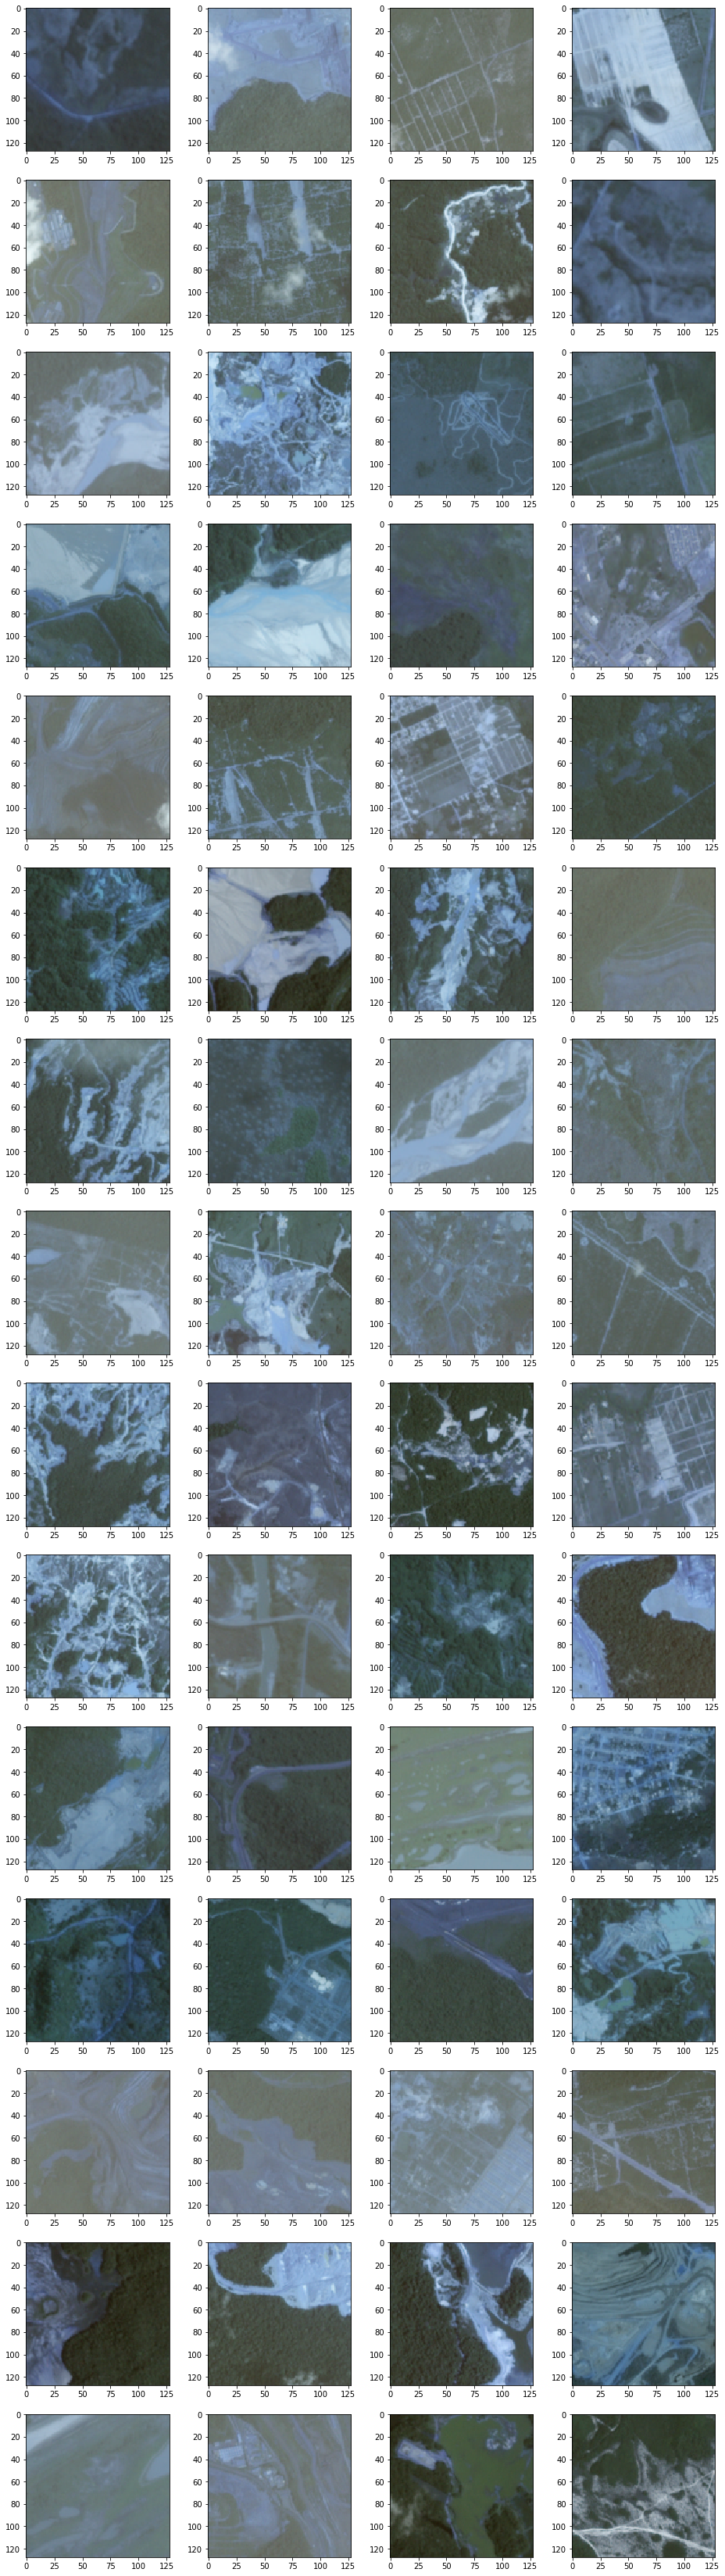

In [170]:
show_examples(changed, 60, cols=4, zoom=4)